# Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram

# Load dataset

In [ ]:
df = pd.read_csv('riding_in_tandem.csv')

# Display dataset preview

In [ ]:
print("\n📌 Dataset Preview:")
print(df.head())


📌 Dataset Preview:
   year    month police_regional_office shooting_incidents_killed  \
0  2011  January                      1                        12   
1  2011  January                      2                         0   
2  2011  January                      3                         9   
3  2011  January                     4A                         7   
4  2011  January                     4B                         0   

  shooting_incidents_wounded shooting_incidents_unharmed  \
0                          5                           1   
1                          0                           0   
2                          5                           0   
3                          6                           2   
4                          0                           0   

  shooting_incidents_total robbery_killed robbery_wounded robbery_unharmed  \
0                       14              0               0                1   
1                        0              0       

# Define crime-related features

In [ ]:
crime_features = ['shooting_incidents_total', 'robbery_total', 'carnapping_total', 'others_total', 'victims_total']
df[crime_features] = df[crime_features].apply(pd.to_numeric, errors='coerce')
df.fillna(0, inplace=True)

# Group data by police region

In [ ]:
region_data = df.groupby('police_regional_office')[crime_features].sum()

# Standardize features

In [ ]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(region_data)

# Elbow Method to determine optimal K for KMeans

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


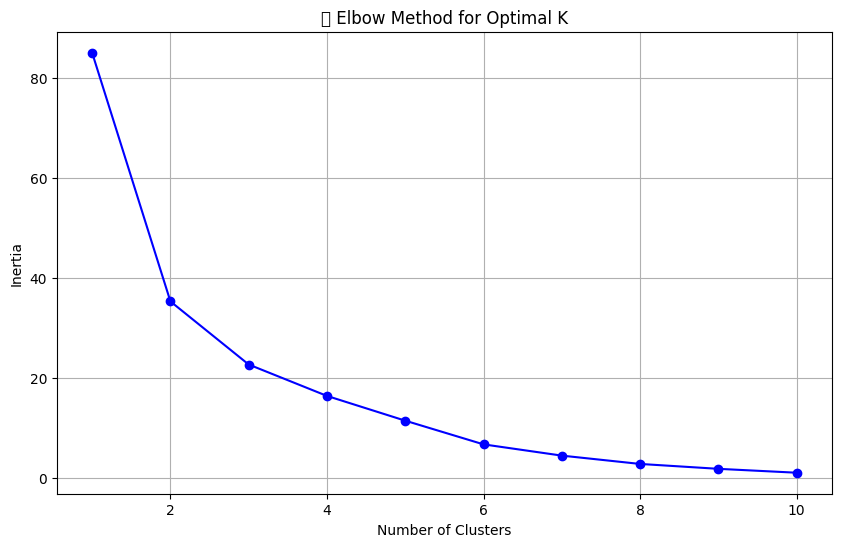

In [ ]:
inertia = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('🔍 Elbow Method for Optimal K')
plt.grid(True)
plt.show()

# Determine optimal epsilon for DBSCAN

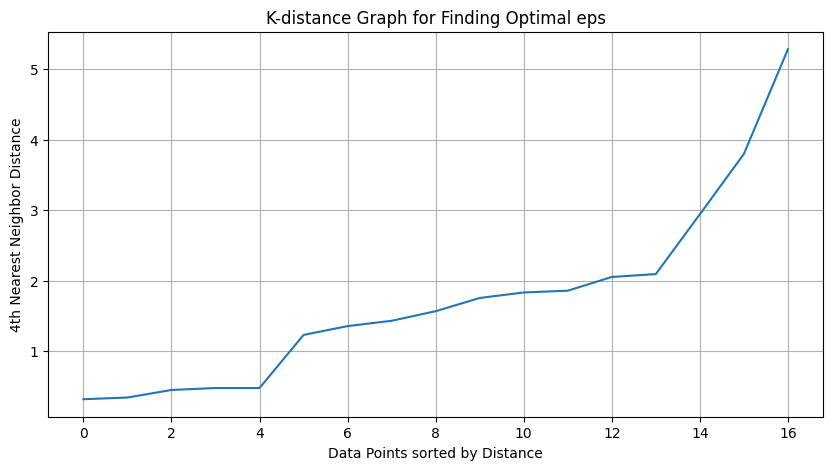

In [ ]:
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(features_scaled)
distances, indices = nbrs.kneighbors(features_scaled)
distances = np.sort(distances[:, 4], axis=0)

plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.xlabel("Data Points sorted by Distance")
plt.ylabel("4th Nearest Neighbor Distance")
plt.title("K-distance Graph for Finding Optimal eps")
plt.grid(True)
plt.show()

# Apply Clustering Algorithms

In [ ]:
optimal_k = 5

# KMeans

In [ ]:
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
region_data['Cluster_KMeans'] = kmeans.fit_predict(features_scaled)

# DBSCAN

In [ ]:
dbscan = DBSCAN(eps=1.5, min_samples=1)
region_data['Cluster_DBSCAN'] = dbscan.fit_predict(features_scaled)

# Agglomerative Clustering

In [ ]:
agg_cluster = AgglomerativeClustering(n_clusters=2)
region_data['Cluster_Agglomerative'] = agg_cluster.fit_predict(features_scaled)

# Calculate Silhouette Scores

In [ ]:
silhouette_agglo = silhouette_score(features_scaled, region_data['Cluster_Agglomerative'])
print(f"Silhouette Score (Agglomerative): {silhouette_agglo:.4f}")

Silhouette Score (Agglomerative): 0.5949


# Print cluster results

In [ ]:
print("\n📌 Clustered Regions (DBSCAN):")
print(region_data[['Cluster_DBSCAN']])
print("\n📌 Clustered Regions (K-Means):")
print(region_data[['Cluster_KMeans']])
print("\n📌 Clustered Regions (Agglomerative):")
print(region_data[['Cluster_Agglomerative']])
print("\n📌 Clustered Regions (DBSCAN):")
print(region_data[['Cluster_DBSCAN']])
print("\n📌 Clustered Regions (K-Means):")
print(region_data[['Cluster_KMeans']])
print("\n📌 Clustered Regions (Agglomerative):")
print(region_data[['Cluster_Agglomerative']])


📌 Clustered Regions (DBSCAN):
                        Cluster_DBSCAN
police_regional_office                
1                                    0
10                                   0
11                                   0
12                                   0
13                                   0
2                                    0
3                                    1
4A                                   2
4B                                   0
5                                    0
6                                    0
7                                    0
8                                    0
9                                    0
ARMM                                 0
COR                                  0
NCRPO                                3

📌 Clustered Regions (K-Means):
                        Cluster_KMeans
police_regional_office                
1                                    0
10                                   0
11                                   4
1

# Dendrogram for Agglomerative Clustering

In [ ]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(features_scaled)

In [ ]:
def plot_dendrogram(model, labels, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(labels)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, np.arange(model.children_.shape[0]), counts]).astype(float)
    dendrogram(linkage_matrix, labels=labels, leaf_rotation=90, leaf_font_size=8, **kwargs)


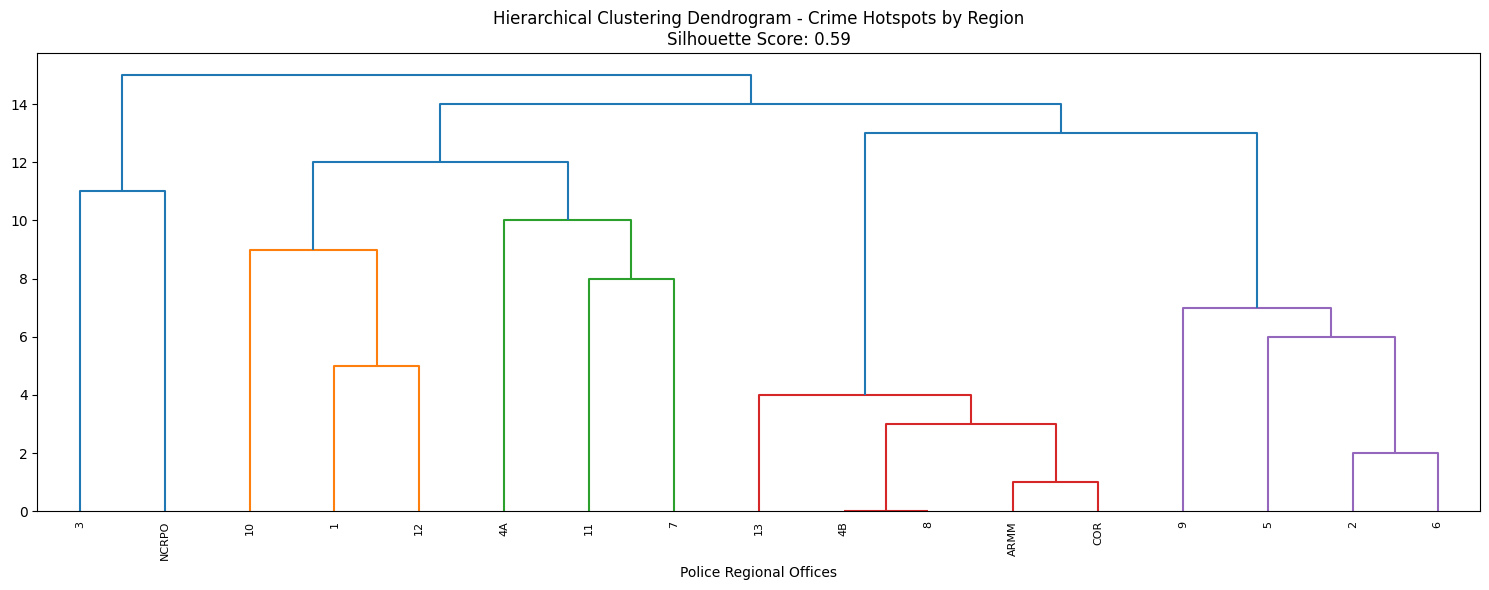

In [ ]:
plt.figure(figsize=(15, 6))
sil_score = silhouette_agglo
plt.title(f'Hierarchical Clustering Dendrogram - Crime Hotspots by Region\nSilhouette Score: {sil_score:.2f}')
plot_dendrogram(model, region_data.index, truncate_mode="level", p=5)
plt.xlabel("Police Regional Offices")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()